In [2]:
# General
import numpy as np
import pandas as pd
import nltk
import random
import os
from os import path
from PIL import Image

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

In [3]:
# Set Plot Theme
sns.set_palette([
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
])
# Alternate # plt.style.use('fivethirtyeight')

# Pre-Processing
import string
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from nltk.stem import PorterStemmer

In [4]:
# Modeling
import statsmodels.api as sm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk.util import ngrams
from collections import Counter
from gensim.models import word2vec

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Read and Peak at Data
df = pd.read_csv("Dataset/Womens Clothing E-Commerce Reviews.csv")
df.drop(df.columns[0],inplace=True, axis=1)

# Delete missing observations for following variables
for x in ["Division Name","Department Name","Class Name","Review Text"]:
    df = df[df[x].notnull()]

# Extracting Missing Count and Unique Count by Column
unique_count = []
for x in df.columns:
    unique_count.append([x,len(df[x].unique()),df[x].isnull().sum()])

# Missing Values
print("Missing Values: {}".format(df.isnull().sum().sum()))

# Data Dimensions
print("Dataframe Dimension: {} Rows, {} Columns".format(*df.shape))

# Create New Variables: 
# Word Length
df["Word Count"] = df['Review Text'].str.split().apply(len)
# Character Length
df["Character Count"] = df['Review Text'].apply(len)
# Boolean for Positive and Negative Reviews
df["Label"] = 0
df.loc[df.Rating >= 3,["Label"]] = 1

Missing Values: 2966
Dataframe Dimension: 22628 Rows, 10 Columns


In [6]:
df.sample(5)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Word Count,Character Count,Label
15970,1056,42,NaN,I looooove these pants. i was looking for a co...,5,1,0,General Petite,Bottoms,Pants,63,309,1
12243,1078,37,Even better in person!,I'm 5' 120 and the 4p fit like a glove. i have...,5,1,1,General Petite,Dresses,Dresses,41,188,1
8557,964,28,Very cute until washed!,I loved this jacket it is very cute until i wa...,5,1,2,General Petite,Jackets,Jackets,42,211,1
5331,1020,45,NaN,Love this skirt length and the detail buttons....,5,1,0,General Petite,Bottoms,Skirts,23,120,1
10300,1033,36,Cute!,These pants were pretty different then my typi...,5,1,1,General,Bottoms,Jeans,48,254,1


In [7]:
print("Dataframe Dimension: {} Rows, {} Columns".format(*df.shape))
pd.DataFrame(unique_count, columns=["Column","Unique","Missing"]).set_index("Column").T

Dataframe Dimension: 22628 Rows, 13 Columns


Column,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
Unique,1172,77,13984,22621,5,2,82,3,6,20
Missing,0,0,2966,0,0,0,0,0,0,0


In [8]:
df.describe().T.drop("count",axis=1)

,mean,std,min,25%,50%,75%,max
Clothing ID,919.695908,201.683804,1.0,861.0,936.0,1078.0,1205.0
Age,43.282880,12.328176,18.0,34.0,41.0,52.0,99.0
Rating,4.183092,1.115911,1.0,4.0,5.0,5.0,5.0
Recommended IND,0.818764,0.385222,0.0,1.0,1.0,1.0,1.0
Positive Feedback Count,2.631784,5.787520,0.0,0.0,1.0,3.0,122.0
Word Count,60.211950,28.533053,2.0,36.0,59.0,88.0,115.0
Character Count,308.761534,143.934126,9.0,186.0,302.0,459.0,508.0
Label,0.895263,0.306222,0.0,1.0,1.0,1.0,1.0


In [9]:
df[["Title", "Division Name","Department Name","Class Name"]].describe(include=["O"]).T.drop("count",axis=1)

,unique,top,freq
Title,13983,Love it!,136
Division Name,3,General,13365
Department Name,6,Tops,10048
Class Name,20,Dresses,6145


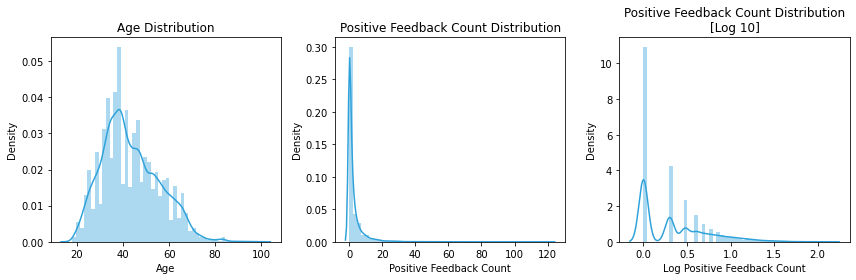

In [10]:
# Continous Distributions
f, ax = plt.subplots(1,3,figsize=(12,4), sharey=False)
sns.distplot(df.Age, ax=ax[0])
ax[0].set_title("Age Distribution")
ax[0].set_ylabel("Density")
sns.distplot(df["Positive Feedback Count"], ax=ax[1])
ax[1].set_title("Positive Feedback Count Distribution")
sns.distplot(np.log10((df["Positive Feedback Count"][df["Positive Feedback Count"].notnull()]+1)), ax=ax[2])
ax[2].set_title("Positive Feedback Count Distribution\n[Log 10]")
ax[2].set_xlabel("Log Positive Feedback Count")
plt.tight_layout()
plt.show()

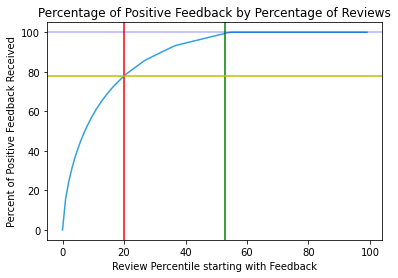

78% of Positive Feedback belongs to the top 20% of Reviews

Gini Coefficient: 0.76


In [11]:
# Percentage Accumulation from "Most Wealthy"
def percentage_accumulation(series, percentage):
    return (series.sort_values(ascending=False)
            [:round(series.shape[0]*(percentage/100))]
     .sum()/series
     .sum()*100)

# Gini Coefficient- Inequality Score
# Source: https://planspace.org/2013/06/21/how-to-calculate-gini-coefficient-from-raw-data-in-python/
def gini(list_of_values):
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2.
    return (fair_area - area) / fair_area

# Cumulative Percentage of Positive Feedback assigned Percent of Reviewers (from most wealthy)
inequality = []
for x in list(range(100)):
    inequality.append(percentage_accumulation(df["Positive Feedback Count"], x))

# Generic Matplotlib Plot
plt.plot(inequality)
plt.title("Percentage of Positive Feedback by Percentage of Reviews")
plt.xlabel("Review Percentile starting with Feedback")
plt.ylabel("Percent of Positive Feedback Received")
plt.axvline(x=20, c = "r")
plt.axvline(x=53, c = "g")
plt.axhline(y=78, c = "y")
plt.axhline(y=100, c = "b", alpha=.3)
plt.show()

# 80-20 Rule Confirmation
print("{}% of Positive Feedback belongs to the top 20% of Reviews".format(
    round(percentage_accumulation(df["Positive Feedback Count"], 20))))

# Gini
print("\nGini Coefficient: {}".format(round(gini(df["Positive Feedback Count"]),2)))

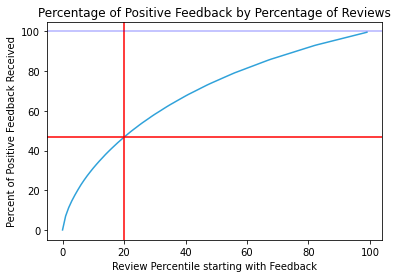

47% of Positive Feedback belongs to the top 20% of Reviews

Gini Coefficient: 0.38


In [12]:
# Cumulative Percentage of Positive Feedback assigned Percent of Reviewers (from most wealthy)
top_20 = df["Positive Feedback Count"].sort_values(ascending=False)[:round(df.shape[0]*(20/100))]

inequality = []
for x in list(range(100)):
    inequality.append(percentage_accumulation(top_20, x))

# Generic Matplotlib Plot
plt.plot(inequality)
plt.title("Percentage of Positive Feedback by Percentage of Reviews")
plt.xlabel("Review Percentile starting with Feedback")
plt.ylabel("Percent of Positive Feedback Received")
plt.axvline(x=20, c = "r")
plt.axhline(y=47, c = "r")
plt.axhline(y=100, c = "b", alpha=.3)

plt.show()

# 80-20 Rule Confirmation
print("{}% of Positive Feedback belongs to the top 20% of Reviews".format(
    round(percentage_accumulation(top_20, 20))))

# Gini
print("\nGini Coefficient: {}".format(round(gini(top_20),2)))

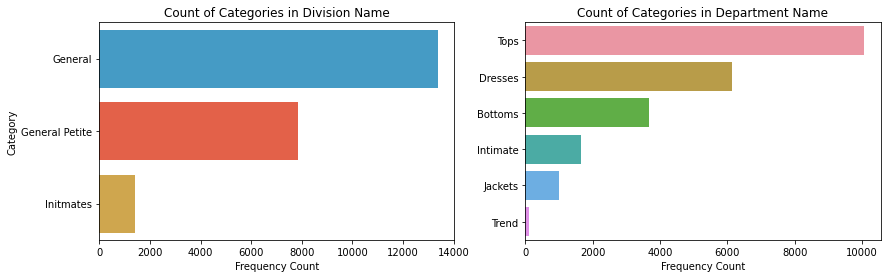

In [13]:
row_plots = ["Division Name","Department Name"]
f, axes = plt.subplots(1,len(row_plots), figsize=(14,4), sharex=False)

for i,x in enumerate(row_plots):
    sns.countplot(y=x, data=df,order=df[x].value_counts().index, ax=axes[i])
    axes[i].set_title("Count of Categories in {}".format(x))
    axes[i].set_xlabel("")
    axes[i].set_xlabel("Frequency Count")
axes[0].set_ylabel("Category")
axes[1].set_ylabel("")
plt.show()

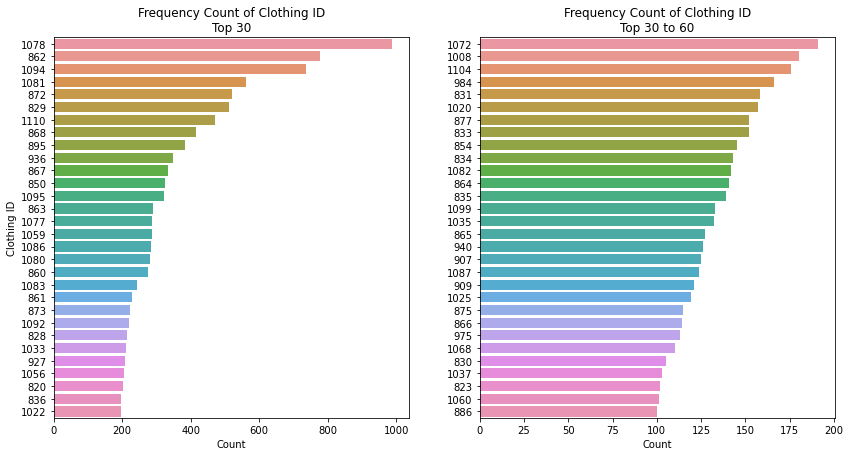

Dataframe Dimension: 22628 Rows


,mean,std,min,25%,50%,75%,max
Clothing ID,1015.4848,103.396022,862.0,862.0,1078.0,1094.0,1094.0
Age,42.7248,12.150429,18.0,34.0,41.0,51.0,99.0
Rating,4.1892,1.104306,1.0,4.0,5.0,5.0,5.0
Recommended IND,0.8184,0.385592,0.0,1.0,1.0,1.0,1.0
Positive Feedback Count,2.8624,6.773021,0.0,0.0,1.0,3.0,98.0
Word Count,60.5912,28.731486,2.0,36.0,60.0,89.0,115.0
Character Count,310.8604,144.836158,16.0,189.0,305.0,469.0,504.0
Label,0.9024,0.296832,0.0,1.0,1.0,1.0,1.0


In [14]:
# Clothing ID Category
f, axes = plt.subplots(1,2, figsize=[14,7])
num = 30
sns.countplot(y="Clothing ID", data = df[df["Clothing ID"].isin(df["Clothing ID"].value_counts()[:num].index)],
              order= df["Clothing ID"].value_counts()[:num].index, ax=axes[0])
axes[0].set_title("Frequency Count of Clothing ID\nTop 30")
axes[0].set_xlabel("Count")

sns.countplot(y="Clothing ID", data = df[df["Clothing ID"].isin(df["Clothing ID"].value_counts()[num:60].index)],
              order= df["Clothing ID"].value_counts()[num:60].index, ax=axes[1])
axes[1].set_title("Frequency Count of Clothing ID\nTop 30 to 60")
axes[1].set_ylabel("")
axes[1].set_xlabel("Count")
plt.show()

print("Dataframe Dimension: {} Rows".format(df.shape[0]))
df[df["Clothing ID"].isin([1078, 862,1094])].describe().T.drop("count",axis=1)

In [15]:
df.loc[df["Clothing ID"].isin([1078, 862,1094]),
       ["Title", "Division Name","Department Name","Class Name"]].describe(include=["O"]).T.drop("count",axis=1)

,unique,top,freq
Title,1815,Beautiful dress,21
Division Name,2,General,1524
Department Name,2,Dresses,1722
Class Name,2,Dresses,1722


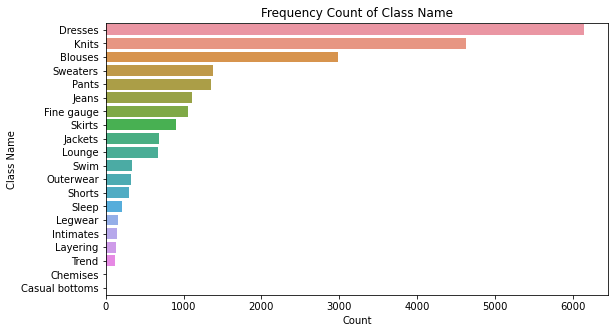

In [16]:
# Class Name
plt.subplots(figsize=(9,5))
sns.countplot(y="Class Name", data=df,order=df["Class Name"].value_counts().index)
plt.title("Frequency Count of Class Name")
plt.xlabel("Count")
plt.show()

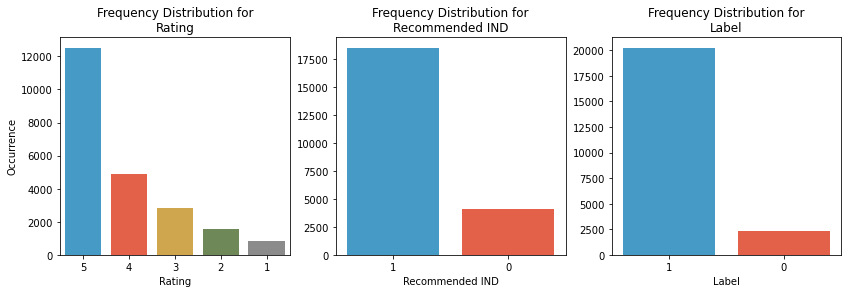

In [17]:
#cat_dtypes = [x for x,y,z in unique_count if y < 10 and x not in ["Division Name","Department Name"]]
cat_dtypes = ["Rating","Recommended IND","Label"]
increment = 0
f, axes = plt.subplots(1,len(cat_dtypes), figsize=(14,4), sharex=False)

for i in range(len(cat_dtypes)):
    sns.countplot(x=cat_dtypes[increment], data=df,order=df[cat_dtypes[increment]].value_counts().index, ax=axes[i])
    axes[i].set_title("Frequency Distribution for\n{}".format(cat_dtypes[increment]))
    axes[i].set_ylabel("Occurrence")
    axes[i].set_xlabel("{}".format(cat_dtypes[increment]))
    increment += 1
axes[1].set_ylabel("")
axes[2].set_ylabel("")
plt.show()

AttributeError: 'NoneType' object has no attribute 'remove'

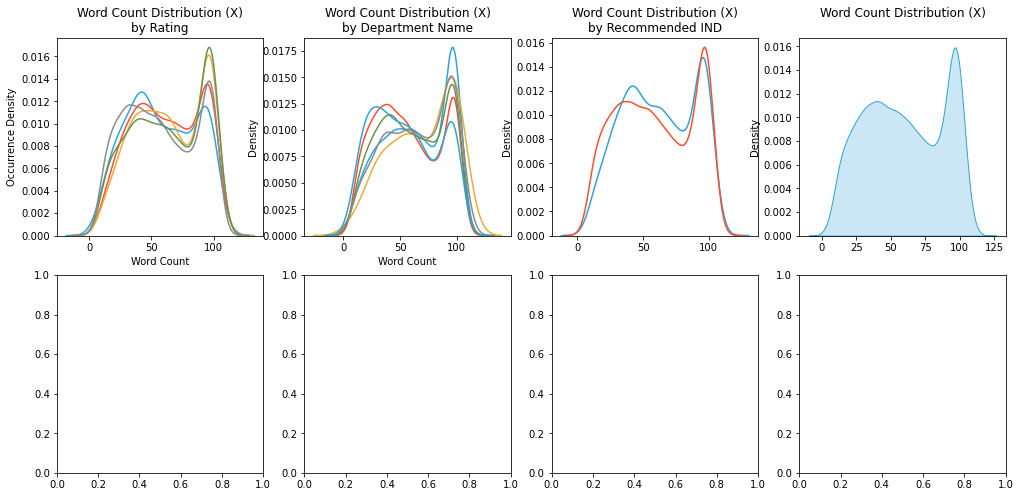

In [18]:
f, axes = plt.subplots(2,4, figsize=(17,8), sharex=False)
for ii, xvar in enumerate(['Word Count', "Character Count"]):
    for i,y in enumerate(["Rating","Department Name","Recommended IND"]):
        for x in set(df[y][df[y].notnull()]):
            sns.kdeplot(df[xvar][df[y]==x], label=x, shade=False, ax=axes[ii,i])
        if ii is 0:
            axes[ii,i].set_title('{} Distribution (X)\nby {}'.format(xvar, y))
        else:
            axes[ii,i].set_title('For {} (X)'.format(xvar))
    axes[ii,0].set_ylabel('Occurrence Density')
    axes[ii,i].set_xlabel('')
    # Plot 4
    sns.kdeplot(df[xvar],shade=True,ax=axes[ii,3])
    axes[ii,3].set_xlabel("")
    if ii is 0:
        axes[ii,3].set_title('{} Distribution (X)\n'.format(xvar))
    else:
        axes[ii,3].set_title('For {} (X)'.format(xvar))
    axes[ii,3].legend_.remove()
plt.show()

print("Correlation Coefficient of Word Cound and Character Count: {}".format(
    round(df["Word Count"].corr(df["Character Count"]), 2)))

print("\nTotal Word Count is: {}".format(df["Word Count"].sum()))
print("Total Character Count is: {}".format(df["Character Count"].sum()))
df[["Word Count","Character Count"]].describe().T

In [ ]:
# Heatmaps of Percentage Pivot Table
f, ax = plt.subplots(1,2,figsize=(16, 4), sharey=True)
sns.heatmap(pd.crosstab(df['Division Name'], df["Department Name"]),
            annot=True, linewidths=.5, ax = ax[0],fmt='g', cmap="Greens",
                cbar_kws={'label': 'Count'})
ax[0].set_title('Division Name Count by Department Name - Crosstab\nHeatmap Overall Count Distribution')

sns.heatmap(pd.crosstab(df['Division Name'], df["Department Name"], normalize=True).mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[1],fmt='g', cmap="Greens",
                cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Division Name Count by Department Name - Crosstab\nHeatmap Overall Percentage Distribution')
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.show()

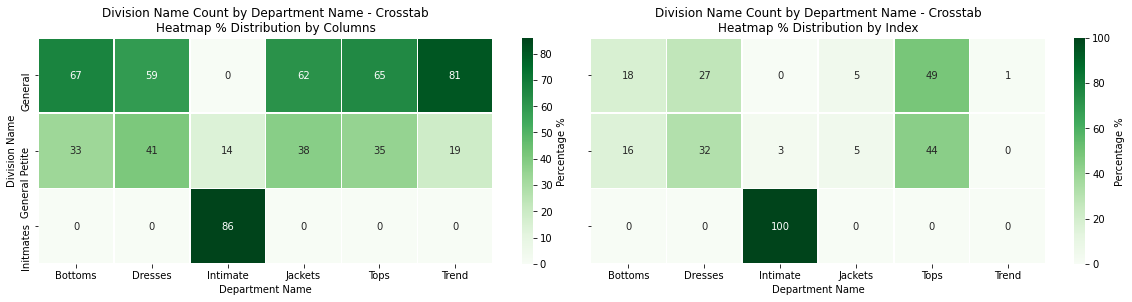

In [19]:
# Heatmaps of Percentage Pivot Table
f, ax = plt.subplots(1,2,figsize=(16, 4), sharey=True)
sns.heatmap(pd.crosstab(df['Division Name'], df["Department Name"], normalize='columns').mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[0],fmt='g', cmap="Greens",
                cbar_kws={'label': 'Percentage %'})
ax[0].set_title('Division Name Count by Department Name - Crosstab\nHeatmap % Distribution by Columns')

sns.heatmap(pd.crosstab(df['Division Name'], df["Department Name"], normalize='index').mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[1],fmt='g', cmap="Greens",
                cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Division Name Count by Department Name - Crosstab\nHeatmap % Distribution by Index')
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.show()

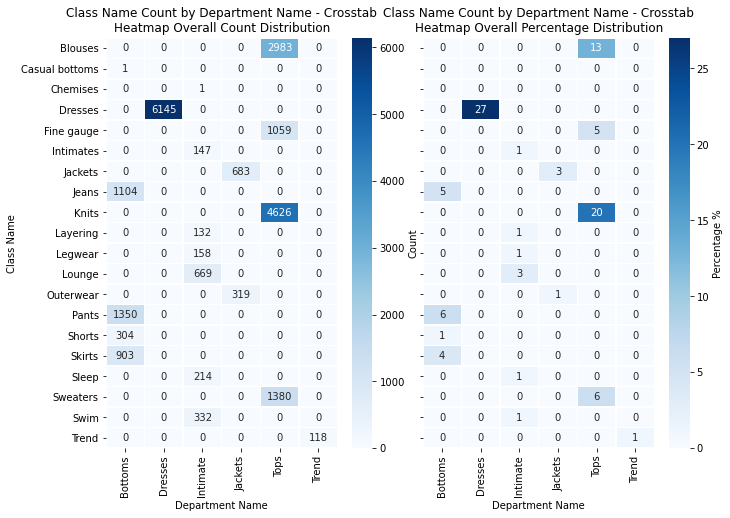

In [20]:
# Heatmaps of Percentage Pivot Table
f, ax = plt.subplots(1,2,figsize=(10, 7), sharey=True)
fsize = 13
sns.heatmap(pd.crosstab(df['Class Name'], df["Department Name"]),
            annot=True, linewidths=.5, ax = ax[0],fmt='g', cmap="Blues",
                cbar_kws={'label': 'Count'})
ax[0].set_title('Class Name Count by Department Name - Crosstab\nHeatmap Overall Count Distribution')

sns.heatmap(pd.crosstab(df['Class Name'], df["Department Name"], normalize=True).mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[1],fmt='g', cmap="Blues",
                cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Class Name Count by Department Name - Crosstab\nHeatmap Overall Percentage Distribution')
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.show()

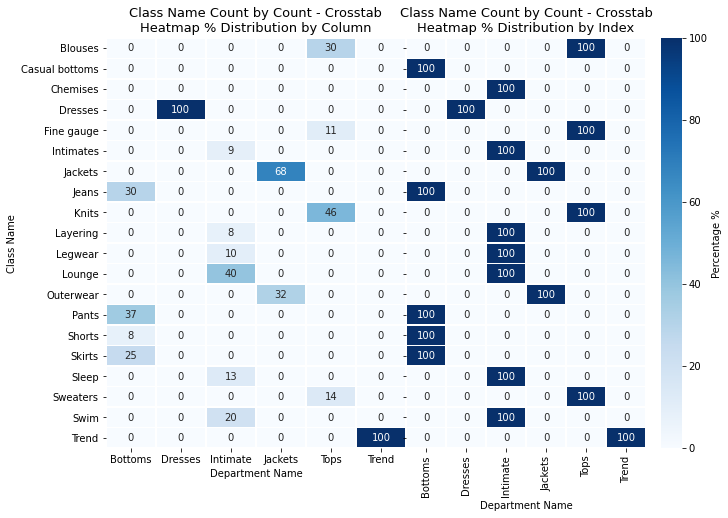

In [21]:
# Heatmaps of Percentage Pivot Table
f, ax = plt.subplots(1,2,figsize=(10, 7), sharey=True)
fsize = 13
sns.heatmap(pd.crosstab(df['Class Name'], df["Department Name"], normalize = 'columns').mul(100).round(0)
            ,annot=True, fmt="g", linewidths=.5, ax=ax[0],cbar=False,cmap="Blues")
ax[0].set_title('Class Name Count by Count - Crosstab\nHeatmap % Distribution by Column', fontsize = fsize)
ax[1] = sns.heatmap(pd.crosstab(df['Class Name'], df["Department Name"], normalize = 'index').mul(100).round(0)
            ,annot=True, fmt="2g", linewidths=.5, ax=ax[1],cmap="Blues",
                cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Class Name Count by Count - Crosstab\nHeatmap % Distribution by Index', fontsize = fsize)
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.show()

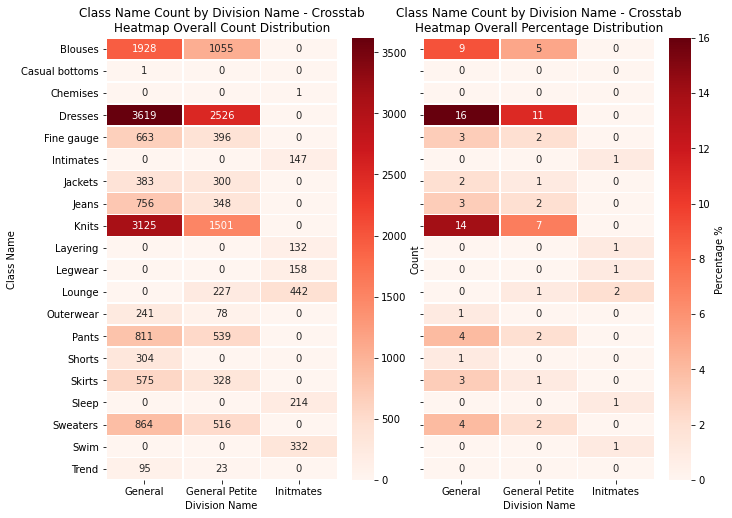

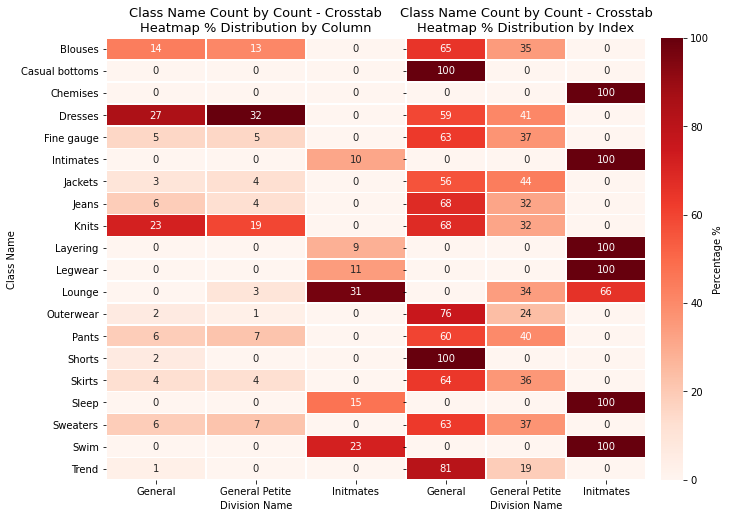

In [22]:
# Heatmaps of Percentage Pivot Table
f, ax = plt.subplots(1,2,figsize=(10, 7), sharey=True)
fsize = 13
sns.heatmap(pd.crosstab(df['Class Name'], df["Division Name"]),
            annot=True, linewidths=.5, ax = ax[0],fmt='g', cmap="Reds",
                cbar_kws={'label': 'Count'})
ax[0].set_title('Class Name Count by Division Name - Crosstab\nHeatmap Overall Count Distribution')

sns.heatmap(pd.crosstab(df['Class Name'], df["Division Name"], normalize=True).mul(100).round(0),
            annot=True, linewidths=.5, ax=ax[1],fmt='g', cmap="Reds",
                cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Class Name Count by Division Name - Crosstab\nHeatmap Overall Percentage Distribution')
ax[1].set_ylabel('')
plt.tight_layout(pad=0)
plt.show()

# Heatmaps of Percentage Pivot Table
f, ax = plt.subplots(1,2,figsize=(10, 7), sharey=True)
fsize = 13
sns.heatmap(pd.crosstab(df['Class Name'], df["Division Name"], normalize = 'columns').mul(100).round(0)
            ,annot=True, fmt="g", linewidths=.5, ax=ax[0],cbar=False,cmap="Reds")
ax[0].set_title('Class Name Count by Count - Crosstab\nHeatmap % Distribution by Column', fontsize = fsize)
ax[1] = sns.heatmap(pd.crosstab(df['Class Name'], df["Division Name"], normalize = 'index').mul(100).round(0)
            ,annot=True, fmt="2g", linewidths=.5, ax=ax[1],cmap="Reds",
                cbar_kws={'label': 'Percentage %'})
ax[1].set_title('Class Name Count by Count - Crosstab\nHeatmap % Distribution by Index', fontsize = fsize)
ax[1].set_ylabel('')
plt.tight_layout(pad=0)

# MANUAL NORMALIZE with Applied Lambda on Pandas DataFrame
# ctab = pd.crosstab(df['Class Name'], df["Rating"]).apply(lambda r: r/r.sum(), axis=1).mul(100)

AttributeError: 'NoneType' object has no attribute 'remove'

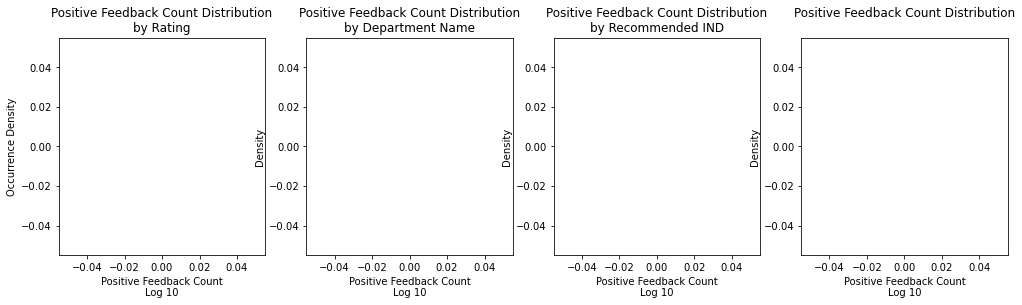

In [23]:
f, axes = plt.subplots(1,4, figsize=(17,4), sharex=False)
xvar = 'Positive Feedback Count'
plotdf = np.log10(df['Positive Feedback Count'])
for i,y in enumerate(["Rating","Department Name","Recommended IND"]):
    for x in set(df[y][df[y].notnull()]):
        sns.kdeplot(plotdf[df[y]==x], label=x, shade=True, ax=axes[i])
    axes[i].set_xlabel("{}\nLog 10".format(xvar))
    axes[i].set_label('Occurrence Density')
    axes[i].set_title('{} Distribution\nby {}'.format(xvar, y))
axes[0].set_ylabel('Occurrence Density')
# Plot 4
sns.kdeplot(plotdf,shade=True,ax=axes[3])
axes[3].set_xlabel("{}\nLog 10".format(xvar))
axes[3].set_title('{} Distribution\n'.format(xvar))
axes[3].legend_.remove()
plt.show()

In [24]:
# Checking inequality difference:
for rec in [0,1]:
    temp = df["Positive Feedback Count"][df["Recommended IND"] == rec]

    print("Recommended is {}".format(rec))
    # 80-20 Rule Confirmation
    print("{}% of Positive Feedback belongs to the top 20% of Reviews with Recommeded = {}".format(
        round(percentage_accumulation(temp, 20)),rec))
    # Gini
    print("Gini Coefficient: {}\n".format(round(gini(temp),2)))

Recommended is 0
75% of Positive Feedback belongs to the top 20% of Reviews with Recommeded = 0
Gini Coefficient: 0.73

Recommended is 1
78% of Positive Feedback belongs to the top 20% of Reviews with Recommeded = 1
Gini Coefficient: 0.76



AttributeError: 'NoneType' object has no attribute 'remove'

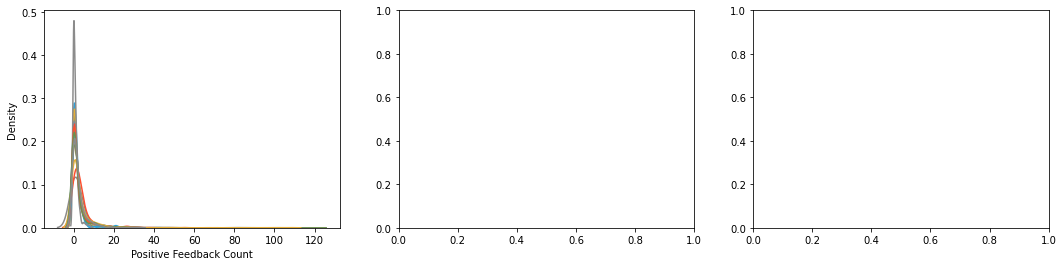

In [25]:
f, axes = plt.subplots(1,3, figsize=(18,4), sharex=False)
for x in set(df["Class Name"][df["Class Name"].notnull()]):
    sns.kdeplot(df['Positive Feedback Count'][df["Class Name"]==x]
                ,label=x, shade=False, ax=axes[0])
    
axes[0].legend_.remove()
axes[0].set_xlabel('{}'.format(xvar))
axes[0].set_title('{} Distribution by {}\n All Data'.format(xvar, "Class Name"))

min_value = 15
for x in set(df["Class Name"][df["Class Name"].notnull()]):
    sns.kdeplot(df['Positive Feedback Count'][(df["Class Name"]==x) &
                                              (df["Positive Feedback Count"] < min_value)]
                ,label=x, shade=False, ax=axes[1])
    
axes[1].legend_.remove()
axes[1].set_xlabel('{}'.format(xvar))
axes[1].set_title('{} Distribution by {}\n Values under {}'.format(xvar, "Class Name", min_value))

for x in set(df["Class Name"][df["Class Name"].notnull()]):
    sns.kdeplot(np.log10(df['Positive Feedback Count']+1)[df["Class Name"]==x]
                ,label=x, shade=False, ax=axes[2])
    
axes[2].legend_.remove()
axes[2].set_xlabel('Log 10 - {}'.format(xvar))
axes[2].set_title('{} Distribution by {}\nAll Data in Log10'.format(xvar, "Class Name"))
plt.show()

AttributeError: 'NoneType' object has no attribute 'remove'

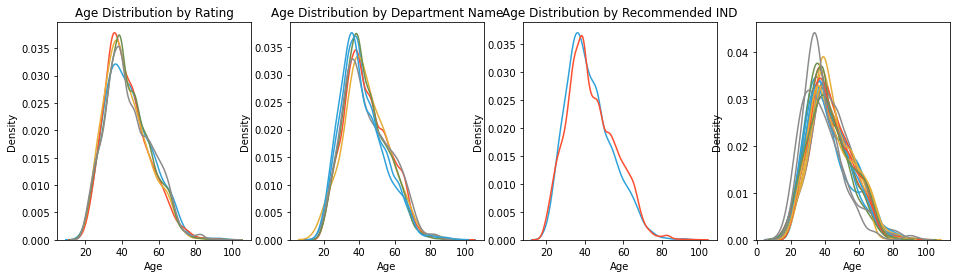

In [26]:
f, axes = plt.subplots(1,4, figsize=(16,4), sharex=False)
xvar = "Age"
plotdf = df["Age"]
for i,y in enumerate(["Rating","Department Name","Recommended IND"]):
    for x in set(df[y][df[y].notnull()]):
        sns.kdeplot(plotdf[df[y]==x], label=x, shade=False, ax=axes[i])
    axes[i].set_xlabel("{}".format(xvar))
    axes[i].set_label('Occurrence Density')
    axes[i].set_title('{} Distribution by {}'.format(xvar, y))

for x in set(df["Class Name"][df["Class Name"].notnull()]):
    sns.kdeplot(plotdf[df["Class Name"]==x], label=x, shade=False, ax=axes[3])

axes[3].legend_.remove()
axes[3].set_xlabel('{}'.format(xvar))
axes[0].set_ylabel('Occurrence Density')
axes[3].set_title('{} Distribution by {}'.format(xvar, "Class Name"))
plt.show()

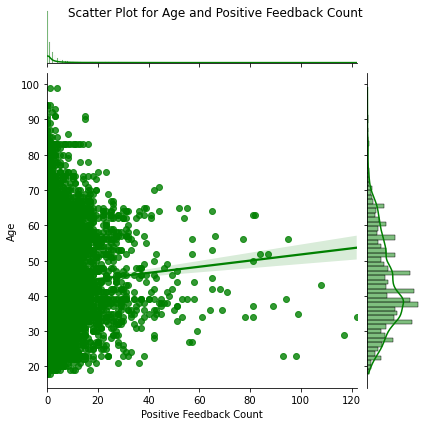

In [27]:
# Normalization is futile here.. But here is a minmax standardization, and a z-score normalization function. 
def minmaxscaler(df):
    return (df-df.min())/(df.max()-df.min())
def zscorenomalize(df):
    return (df - df.mean())/df.std()

g = sns.jointplot(x= df["Positive Feedback Count"], y=df["Age"], kind='reg', color='g')
g.fig.suptitle("Scatter Plot for Age and Positive Feedback Count")
plt.show()

In [28]:
def percentstandardize_barplot(x,y,hue, data, ax=None, order= None):
    """
    Standardize by percentage the data using pandas functions, then plot using Seaborn.
    Function arguments are and extention of Seaborns'.
    """
    sns.barplot(x= x, y=y, hue=hue, ax=ax, order=order,
    data=(data[[x, hue]]
     .reset_index(drop=True)
     .groupby([x])[hue]
     .value_counts(normalize=True)
     .rename('Percentage').mul(100)
     .reset_index()
     .sort_values(hue)))
    plt.title("Percentage Frequency of {} by {}".format(hue,x))
    plt.ylabel("Percentage %")

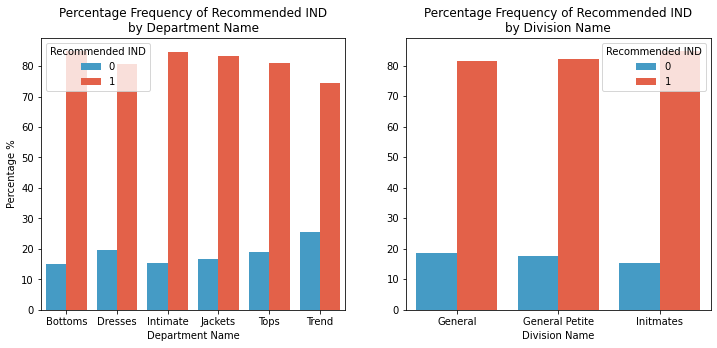

In [29]:
huevar = "Recommended IND"
f, axes = plt.subplots(1,2,figsize=(12,5))
percentstandardize_barplot(x="Department Name",y="Percentage", hue=huevar,data=df, ax=axes[0])
axes[0].set_title("Percentage Frequency of {}\nby Department Name".format(huevar))
axes[0].set_ylabel("Percentage %")
percentstandardize_barplot(x="Division Name",y="Percentage", hue=huevar,data=df, ax=axes[1])
axes[1].set_title("Percentage Frequency of {}\nby Division Name".format(huevar))
axes[1].set_ylabel("")
plt.show()

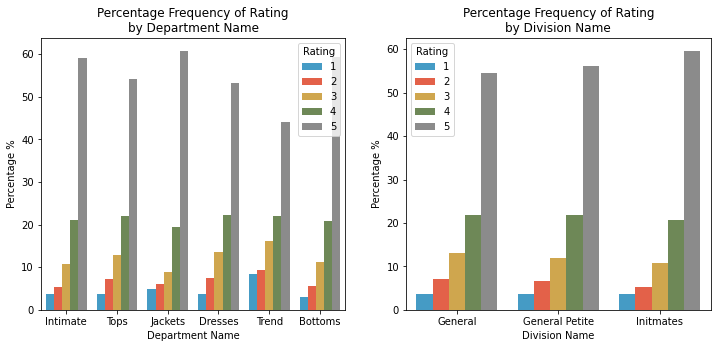

In [30]:
xvar = ["Department Name","Division Name"]
huevar = "Rating"
f, axes = plt.subplots(1,2,figsize=(12,5))
percentstandardize_barplot(x=xvar[0],y="Percentage", hue=huevar,data=df, ax=axes[0])
axes[0].set_title("Percentage Frequency of {}\nby {}".format(huevar, xvar[0]))
axes[0].set_ylabel("Percentage %")
percentstandardize_barplot(x=xvar[1],y="Percentage", hue="Rating",data=df, ax=axes[1])
axes[1].set_title("Percentage Frequency of {}\nby {}".format(huevar, xvar[1]))
plt.show()

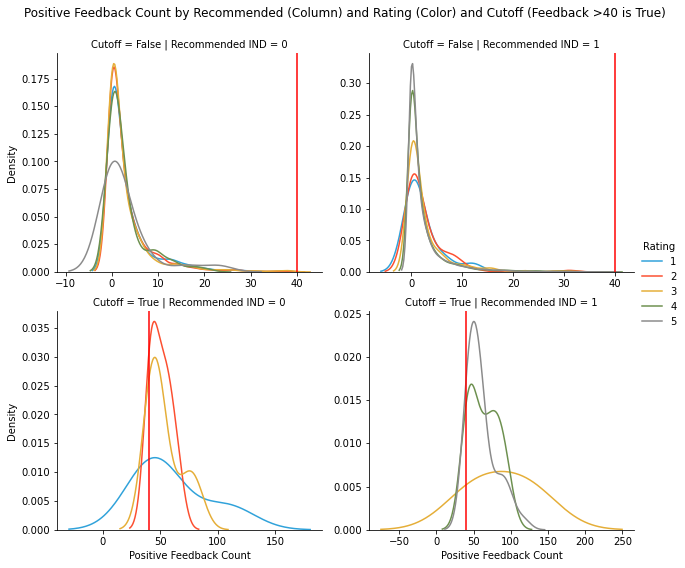

In [31]:
# Cuttoff Variable
df["Cutoff"] = df["Positive Feedback Count"] >= 40 # Temporary variable for facetgrid
# Facet Grid Plot
g = sns.FacetGrid(df, row = "Cutoff", col="Recommended IND",
                  hue="Rating", size=4, aspect=1.1, sharey=False, sharex=False)
g.map(sns.distplot, "Positive Feedback Count", hist=False)
g.add_legend()
g.axes[0,0].set_ylabel('Density')
g.axes[1,0].set_ylabel('Density')
plt.subplots_adjust(top=0.90)
g.fig.suptitle('Positive Feedback Count by Recommended (Column) and Rating (Color) and Cutoff (Feedback >40 is True)')

# Give cutoff line to each plot.
for x in [0,1]:
    for y in [0,1]:
        g.axes[x,y].axvline(x=40, c="r")

plt.show()
del df["Cutoff"]

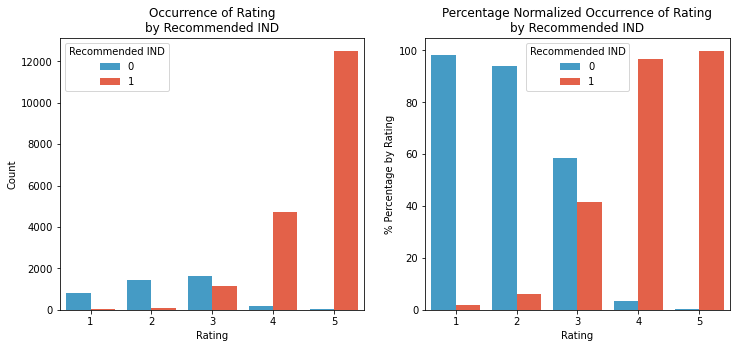

In [32]:
huevar = "Rating"
f, axes = plt.subplots(1,2,figsize=(12,5))
sns.countplot(x="Rating", hue="Recommended IND",data=df, ax=axes[0])
axes[0].set_title("Occurrence of {}\nby {}".format(huevar, "Recommended IND"))
axes[0].set_ylabel("Count")
percentstandardize_barplot(x="Rating",y="Percentage", hue="Recommended IND",data=df, ax=axes[1])
axes[1].set_title("Percentage Normalized Occurrence of {}\nby {}".format(huevar, "Recommended IND"))
axes[1].set_ylabel("% Percentage by Rating")
plt.show()

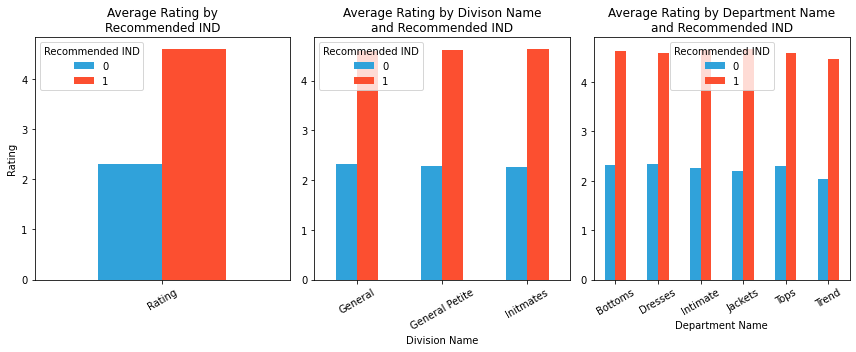

In [33]:
f, axes = plt.subplots(1,3,figsize=(12,5))
rot = 30
df.pivot_table('Rating',
               columns=['Recommended IND']).plot.bar(ax=axes[0],rot=rot)
axes[0].set_title("Average Rating by\nRecommended IND")
df.pivot_table('Rating', index='Division Name',
               columns=['Recommended IND']).plot.bar(ax=axes[1], rot=rot)
axes[1].set_title("Average Rating by Divison Name\nand Recommended IND")
df.pivot_table('Rating', index='Department Name',
               columns=['Recommended IND']).plot.bar(ax=axes[2], rot=rot)
axes[0].set_ylabel("Rating")
axes[2].set_title("Average Rating by Department Name\nand Recommended IND")
f.tight_layout()
plt.show()

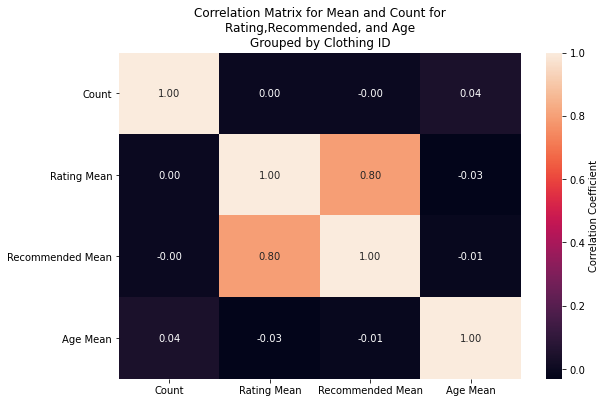

In [34]:
temp = (df.groupby('Clothing ID')[["Rating","Recommended IND", "Age"]]
        .aggregate(['count','mean']))
temp.columns = ["Count","Rating Mean","Recommended IND Count",
                "Recommended Mean","Age Count","Age Mean"]
temp.drop(["Recommended IND Count","Age Count"], axis=1, inplace =True)

# Plot Correlation Matrix
f, ax = plt.subplots(figsize=[9,6])
ax = sns.heatmap(temp.corr()
    , annot=True, fmt=".2f",cbar_kws={'label': 'Correlation Coefficient'})
ax.set_title("Correlation Matrix for Mean and Count for\nRating,Recommended, and Age\nGrouped by Clothing ID")
plt.show()

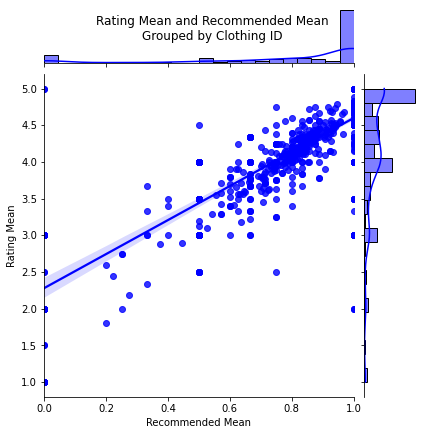

In [35]:
g = sns.jointplot(x= "Recommended Mean",y='Rating Mean',data=temp,
                  kind='reg', color='b')
plt.subplots_adjust(top=0.999)
g.fig.suptitle("Rating Mean and Recommended Mean\nGrouped by Clothing ID")
plt.show()

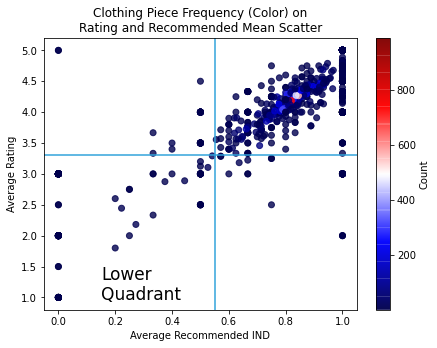

,Count,Rating Mean,Recommended Mean,Age Mean
count,204.000000,204.000000,204.000000,204.000000
mean,2.308824,2.763338,0.316315,41.883954
std,2.798261,0.819220,0.351723,10.858979
min,1.000000,1.000000,0.000000,20.000000
25%,1.000000,2.136364,0.000000,34.687500
50%,1.000000,3.000000,0.250000,41.142857
75%,2.000000,3.000000,0.500000,47.000000
max,24.000000,5.000000,1.000000,74.000000


In [36]:
plt.figure(figsize=(7,5))
plt.scatter(temp["Recommended Mean"],temp["Rating Mean"],
            alpha = .8, c =temp["Count"], cmap = 'seismic')
cbar = plt.colorbar() # Color bar. Vive la France!
cbar.set_label('Count', rotation=90)
plt.xlabel("Average Recommended IND")
plt.ylabel("Average Rating")
plt.title("Clothing Piece Frequency (Color) on\nRating and Recommended Mean Scatter")

# Vertical and Horizontal Lines
l = plt.axhline(y=3.3)
l = plt.axvline(x=.55)

# Text
plt.text(.15, 1, "Lower\nQuadrant", ha='left',wrap=True,fontsize=17)
plt.show()

# Descriptives for LOW QUADRANT
temp[(temp["Rating Mean"] < 3.3) | (temp["Recommended Mean"] <= .55)].describe()

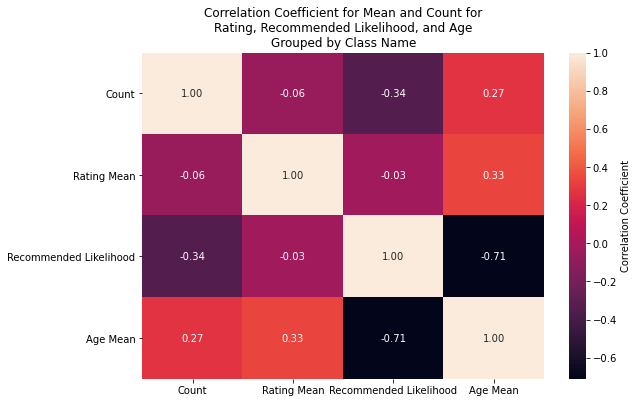

Class Categories:
 ['Intimates' 'Dresses' 'Pants' 'Blouses' 'Knits' 'Outerwear' 'Lounge'
 'Sweaters' 'Skirts' 'Fine gauge' 'Sleep' 'Jackets' 'Swim' 'Trend' 'Jeans'
 'Legwear' 'Shorts' 'Layering' 'Casual bottoms' 'Chemises']


In [37]:
key = "Class Name"
temp = (df.groupby(key)[["Rating","Recommended IND", "Age"]]
        .aggregate(['count','mean']))
temp.columns = ["Count","Rating Mean","Recommended Likelihood Count",
                "Recommended Likelihood","Age Count","Age Mean"]
temp.drop(["Recommended Likelihood Count","Age Count"], axis=1, inplace =True)

# Plot Correlation Matrix
f, ax = plt.subplots(figsize=[9,6])
ax = sns.heatmap(temp.corr()
    , annot=True, fmt=".2f",cbar_kws={'label': 'Correlation Coefficient'})
ax.set_title("Correlation Coefficient for Mean and Count for\nRating, Recommended Likelihood, and Age\nGrouped by {}".format(key))
plt.show()
print("Class Categories:\n",df["Class Name"].unique())

(0.7, 1.01)

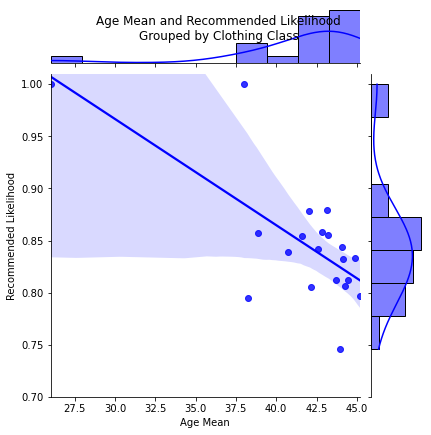

In [38]:
# Simple Linear Regression Model
model_fit = sm.OLS(temp["Recommended Likelihood"],
               sm.add_constant(temp["Age Mean"])).fit() 
temp['resid'] = model_fit.resid

# Plot
g = sns.jointplot(y="Recommended Likelihood",x='Age Mean',data=temp,
                  kind='reg', color='b')
plt.subplots_adjust(top=0.999)
g.fig.suptitle("Age Mean and Recommended Likelihood\nGrouped by Clothing Class")
plt.ylim(.7, 1.01)

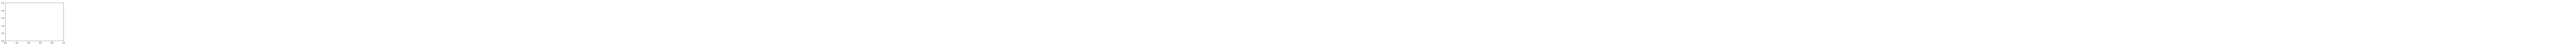

,Count,Rating Mean,Recommended Likelihood,Age Mean,resid
Class Name,,,,,
Casual bottoms,1,4.0,1.0,26.0,-0.007388
Chemises,1,4.0,1.0,38.0,0.114893


In [39]:
# Annotate Outliers
head = temp.sort_values(by=['resid'], ascending=[False]).head(2)
tail = temp.sort_values(by=['resid'], ascending=[False]).tail(2)

def ann(row):
    ind = row[0]
    r = row[1]
    plt.gca().annotate(ind, xy=( r["Age Mean"], r["Recommended Likelihood"]), 
            xytext=(2,2) , textcoords ="offset points", )

for row in head.iterrows():
    ann(row)
for row in tail.iterrows():
    ann(row)

plt.show()
del head, tail

temp[temp["Recommended Likelihood"] > .95]

In [40]:
pd.set_option('max_colwidth', 500)
df[["Title","Review Text", "Rating"]].sample(7)

,Title,Review Text,Rating
9772,Wow ! size down 2 sizes !,"Soft and cozy, the orange is vibrant, the green is more subtle and has gray tones. usually wear a small, bought the xxs ! too full and too sloppy in the xs ad small.",5
12089,This is a must have!!!,I absolutely love this shawl/jacket! i usually use it as outerwear and it is the perfect piece for those in between weather days in new england when it's too cold for winter wear and not warm enough to go without a jacket. the black/brown works great with whatever you're wearing. so versatile and i love that it has pockets!,5
17526,Much cuter than the picture,"This sweater is so much cuter than the online picture makes it look! i think the model is wearing it too large. anyway, this runs kind of big, so size down. it's kind of short in the front, but it hits at a nice, flattering spot. love it.",5
14234,Would definitely recommend,"This top is just as pretty in person as it is online. i usually buy petites, but ordered this one in the regular length and i'm glad i did. perfect on me at 5'2"". my usual size medium fit great everywhere else too. love their fabric choice as well. i'm getting really tired of the thin cottons and slub jersey materials being used so often now. deletta made my day once again!!!",5
164,So pretty!,"I bought this and like other reviews, agree that the quality probably could be better, but i still love it enough to keep. the buckle fell apart, but i was able to fix it and the zipper seems a little weak. it has pilled, but the fabric is textured, so i didn't even notice until i read the other reviews and then looked back at my jacket. it is a perfect medium coat for 40's & 50's before i am ready to bust out my ugly down north face for winter. i get compliments every time i wear it! love!!",4
6505,Cutest skirt ever!,The fit on this skirt is flawless. i usually need alterations at the waist but this one was perfect for me. the buttons are so adorable and the color (orange) is vibrant and perfect for spring and summer. will wear this a lot!,5
15857,NaN,Very soft color and soft to touch. the material is light and airy and it feels great on. i wear a medium and bought the small. i would definitely buy this in another pattern if they made it as cute as the flamingos.,5


In [41]:
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
#ps = LancasterStemmer()
ps = PorterStemmer()

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

def preprocessing(data):
    txt = data.str.lower().str.cat(sep=' ') #1
    words = tokenizer.tokenize(txt) #2
    words = [w for w in words if not w in stop_words] #3
    #words = [ps.stem(w) for w in words] #4
    return words

In [42]:
# Pre-Processing
SIA = SentimentIntensityAnalyzer()
df["Review Text"]= df["Review Text"].astype(str)

In [43]:
# Applying Model, Variable Creation
df['Polarity Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['compound'])
df['Neutral Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['neu'])
df['Negative Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['neg'])
df['Positive Score']=df["Review Text"].apply(lambda x:SIA.polarity_scores(x)['pos'])

In [44]:
# Converting 0 to 1 Decimal Score to a Categorical Variable
df['Sentiment']=''
df.loc[df['Polarity Score']>0,'Sentiment']='Positive'
df.loc[df['Polarity Score']==0,'Sentiment']='Neutral'
df.loc[df['Polarity Score']<0,'Sentiment']='Negative'

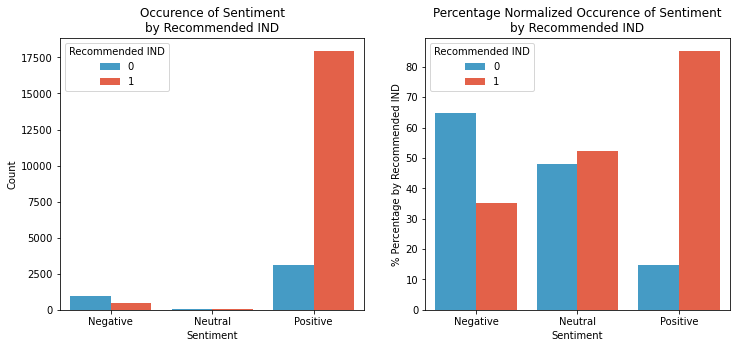

In [45]:
huevar = "Recommended IND"
xvar = "Sentiment"
f, axes = plt.subplots(1,2,figsize=(12,5))
sns.countplot(x=xvar, hue=huevar,data=df, ax=axes[0], order=["Negative","Neutral","Positive"])
axes[0].set_title("Occurence of {}\nby {}".format(xvar, huevar))
axes[0].set_ylabel("Count")
percentstandardize_barplot(x=xvar,y="Percentage", hue=huevar,data=df, ax=axes[1])
axes[1].set_title("Percentage Normalized Occurence of {}\nby {}".format(xvar, huevar))
axes[1].set_ylabel("% Percentage by {}".format(huevar))
plt.show()

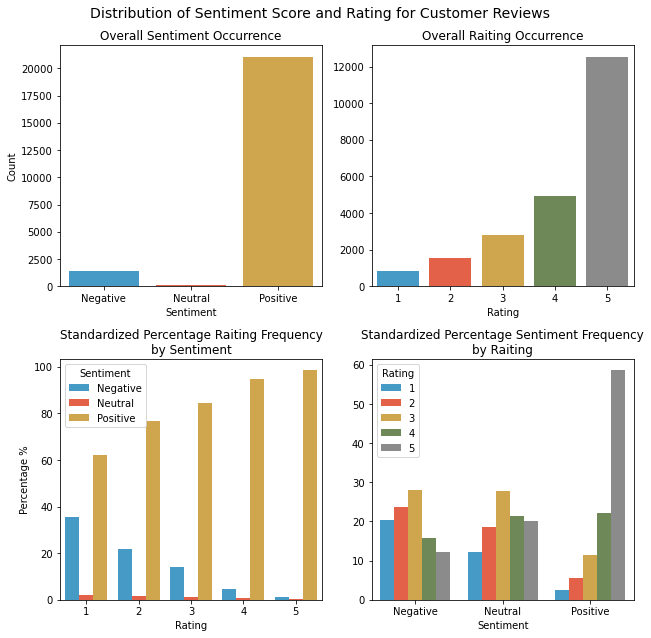

In [46]:
f, axes = plt.subplots(2,2, figsize=[9,9])
sns.countplot(x="Sentiment", data=df, ax=axes[0,0], order=["Negative","Neutral","Positive"])
axes[0,0].set_xlabel("Sentiment")
axes[0,0].set_ylabel("Count")
axes[0,0].set_title("Overall Sentiment Occurrence")

sns.countplot(x="Rating", data=df, ax=axes[0,1])
axes[0,1].set_xlabel("Rating")
axes[0,1].set_ylabel("")
axes[0,1].set_title("Overall Raiting Occurrence")

percentstandardize_barplot(x="Rating",y="Percentage",hue="Sentiment",data=df, ax=axes[1,0])
axes[1,0].set_xlabel("Rating")
axes[1,0].set_ylabel("Percentage %")
axes[1,0].set_title("Standardized Percentage Raiting Frequency\nby Sentiment")

percentstandardize_barplot(x="Sentiment",y="Percentage",hue="Rating",data=df, ax=axes[1,1])
axes[1,1].set_ylabel("Occurrence Frequency")
axes[1,1].set_title("Standardized Percentage Sentiment Frequency\nby Raiting")
axes[1,1].set_xlabel("Sentiment")
axes[1,1].set_ylabel("")

f.suptitle("Distribution of Sentiment Score and Rating for Customer Reviews", fontsize=14)
f.tight_layout()
f.subplots_adjust(top=0.92)
plt.show()

In [47]:
# Tweakable Variables (Note to Change Order Arguement if Xvar is changed)
xvar = "Sentiment"
huevar = "Department Name"
rowvar = "Recommended IND"

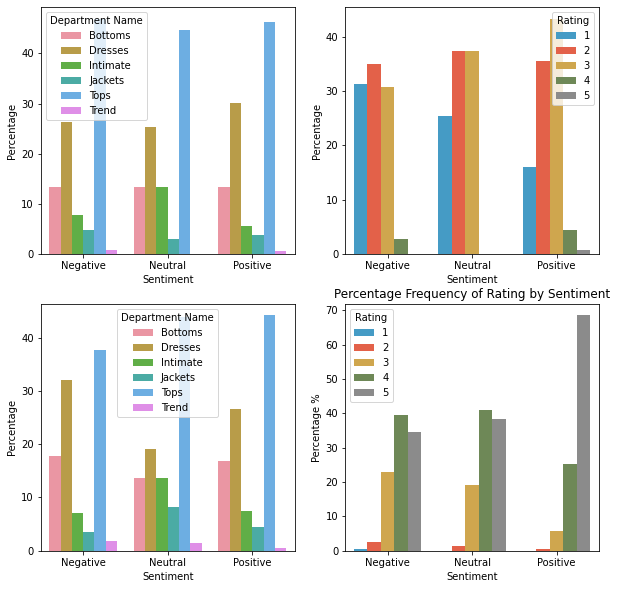

In [48]:
# Plot
f, axes = plt.subplots(2,2,figsize=(10,10), sharex=False,sharey=False)
for i,x in enumerate(set(df[rowvar][df[rowvar].notnull()])):
    percentstandardize_barplot(x=xvar,y="Percentage", hue=huevar,data=df[df[rowvar] == x],
                 ax=axes[i,0], order=["Negative","Neutral","Positive"])
    percentstandardize_barplot(x=xvar,y="Percentage", hue="Rating",data=df[df[rowvar] == x],
                 ax=axes[i,1], order=["Negative","Neutral","Positive"])

In [49]:
# Plot Aesthetics
axes[1,0].legend_.remove()
axes[1,1].legend_.remove()
axes[0,1].set_ylabel("")
axes[1,1].set_ylabel("")
axes[0,0].set_xlabel("")
axes[0,1].set_xlabel("")
axes[0,0].set_ylabel("Recommended = FALSE\nPercentage %")
axes[1,0].set_ylabel("Recommended = TRUE\nPercentage %")
axes[1,1].set_title("")

Text(0.5, 1.0, '')